# Building the 1D CNN

### Import the relevant packages

In [18]:
%matplotlib inline
import context
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import subprocess
import sys
from tqdm import tqdm

import tensorflow as tf
# tf.get_variable('test_bool', 1, tf.bool)
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import (Add, Concatenate, Input, Dense, 
                                            Dropout, Embedding, Conv1D, 
                                            MaxPooling1D, GlobalAveragePooling1D, 
                                            Flatten)
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import StratifiedKFold

ROOT_DIR = os.getcwd() + '/'
CHECKPOINTS_DIR = ROOT_DIR + 'checkpoints/'
construct = context.construct_neural_net
encode = context.encode_sequences
organize = context.organize_data

### Define the input data

#### Using the full data set

In [2]:
sample_filename = ('20190612130111781831_percentiles_els_binarized_homogeneous_deflanked_'
                   'sequences_with_exp_levels.txt.gz')

#### Using a smaller sample set

In [3]:
sample_filename = '10000_from_' + sample_filename 

#### Define the absolute path

In [4]:
sample_path = ROOT_DIR + '../../../example/processed_data/' + sample_filename

### Encode sequences

In [5]:
X_padded, y_scaled, abs_max_el = encode.encode_sequences_with_method(sample_path, method='One-Hot', scale_els=True, model_type='1DCNN', binarized_els=True)
num_seqs, max_sequence_len = organize.get_num_and_len_of_seqs_from_file(sample_path)


In [6]:
min(y_scaled)

0

### Reshape expression levels

In [7]:
y_scaled = y_scaled.reshape((len(y_scaled), 1))
# scaler = MinMaxScaler()
# scaler.fit(y_scaled)
# y_scaled = scaler.transform(y_scaled)

### Perform a train-test split

In [38]:
test_size = 0.30

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_scaled, test_size=test_size)

## Build the model architectures

### Sequential Model

In [10]:
# Define the model parameters
batch_size = len(y_scaled) * 0.01 # no bigger than 1 % of data
filters = 15
kernel_size = 3
strides = 1
epochs = 20
dropout = 0.5

# Define the tensorboard and checkpointer if desired
tb = TensorBoard(log_dir='./logs', 
                 histogram_freq=3, 
                 batch_size=batch_size, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=(CHECKPOINTS_DIR + '1dcnn_sequential_onehot.hdf5'), 
                               verbose=1, 
                               save_best_only=True)


# Define the model
model = Sequential()

# Build up the layers
model.add(Conv1D(filters, kernel_size, activation='relu', 
                 input_shape=(max_sequence_len, 5), 
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D(3, strides))
#     keras.layers.Flatten(data_format=None)
# model.add(GlobalAveragePooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalAveragePooling1D())

# Add some dense and dropout layers
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())
    

W0613 17:17:59.130264 4569744832 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0613 17:17:59.131922 4569744832 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 78, 15)            240       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 15)            690       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 15)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 72, 15)            690       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 70, 15)            690       
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dropout (Dropout)            (None, 15)                0

### Parallel Model

In [13]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 10
dropout = 0.1
num_layers = 10

# Define the tensorboard and checkpointer if desired
tb = TensorBoard(log_dir='./logs', 
                 histogram_freq=3, 
                 batch_size=batch_size, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=(CHECKPOINTS_DIR + '1dcnn_parallel_onehot.hdf5'), 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(1, num_layers + 1):
    layer = Conv1D(filters, (2 * i - 1), strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
# out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())

W0613 17:18:56.584307 4569744832 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0613 17:18:56.586462 4569744832 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 80, 15)       90          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 78, 15)       240         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 76, 15)       390         input_2[0][0]                    
____________________________________________________________________________________________

### Classifier

In [40]:
# Define the model parameters
batch_size = int(len(y_scaled) * 0.01)  # no bigger than 1 % of data
filters = 15
# kernel_size
strides = 1
epochs = 10
dropout = 0.1
num_layers = 10

# Define the tensorboard and checkpointer if desired
tb = TensorBoard(log_dir='./logs', 
                 histogram_freq=3, 
                 batch_size=batch_size, 
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True)
checkpointer = ModelCheckpoint(monitor='val_acc', 
                               filepath=(CHECKPOINTS_DIR + '1dcnn_classifier_onehot.hdf5'), 
                               verbose=1, 
                               save_best_only=True)

# Define the inputs
inputs = Input(shape=(max_sequence_len, 5))
layers = []

# Build up the layers
for i in range(2, num_layers + 1):
    kernel_size = (2 * i - 1)
#     strides = kernel_size
    layer = Conv1D(filters, kernel_size, strides)(inputs)
    layers.append(layer)

# Combine the layers
combined = Concatenate(axis=1)(layers)

# Add some flatten, dense, and dropout layers
out = Flatten()(combined)
out = Dropout(dropout)(out)
out = Dense(500, activation='sigmoid')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation='sigmoid')(out)
# out = Dropout(dropout)(out)

# Define the model with inputs and outputs, and compile.
model = Model(inputs=inputs, outputs=out)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Print model summary
print(model.summary())

W0613 18:26:50.170857 4569744832 callbacks.py:1466] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.
W0613 18:26:50.172261 4569744832 callbacks.py:1469] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 80, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_127 (Conv1D)             (None, 78, 15)       240         input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_128 (Conv1D)             (None, 76, 15)       390         input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 74, 15)       540         input_14[0][0]                   
___________________________________________________________________________________________

### Fit and Evaluate the model

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
6900/7000 [============================>.] - ETA: 0s - loss: 0.7732 - acc: 0.6577
Epoch 00001: val_acc improved from -inf to 0.70767, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/checkpoints/1dcnn_classifier_onehot.hdf5
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.7703 - acc: 0.6584 - val_loss: 0.5642 - val_acc: 0.7077
Epoch 2/10
6900/7000 [============================>.] - ETA: 0s - loss: 0.5582 - acc: 0.7086
Epoch 00002: val_acc improved from 0.70767 to 0.72767, saving model to /Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/expressyeaself/models/1d_cnn/checkpoints/1dcnn_classifier_onehot.hdf5
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.5577 - acc: 0.7086 - val_loss: 0.5456 - val_acc: 0.7277
Epoch 3/10
6900/7000 [============================>.] - ETA: 0s - loss: 0.5239 - acc: 0.7390
Epoch 00003: v

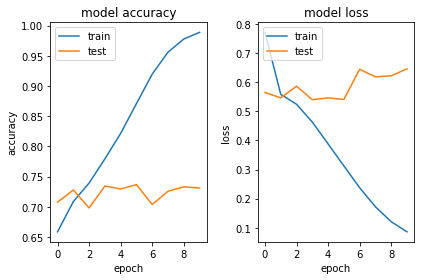

In [41]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpointer])


# Evaluate the model
score = max(history.history['val_acc'])
print("%s: %.2f%%" % (model.metrics_names[1], score*100))
plt = construct.plot_results(history.history)
plt.show()

## Testing the model on native data

In [42]:
native_data = '/Users/joe.abbott/Documents/dataScience/capstone/ExpressYeaself/example/native_data/native_data.txt'

In [47]:
native_df = pd.read_csv(native_data, sep='\t', keep_default_na=False)

In [48]:
native_df

,seq,isNative,EL.originalHQ,EL.rep1,EL.rep2,EL.combined
0,AACTGCATTTTTTTCACATCAAAAAGCGTCCCATAACCCATTATGG...,False,5.53443621041227,6.01582188960043,3.13356537988599,5.3747928587784
1,AACTGCATTTTTTTCACATCAAAAGCGTAAGTTGCCCCCACGTTTT...,False,12.9093976179852,12.066980214217,8.91432298428547,11.6688079710966
2,AACTGCATTTTTTTCACATCAACAGTGTGGCGCTGTGTGGTTTCGA...,False,14.2016886849508,12.9450275112129,10.9724846736912,13.6822701313438
3,AACTGCATTTTTTTCACATCAGTAAAGCTCCGTTTCTTCCAGTTTT...,False,9.68284540194134,9.03400561516769,5.76362038698236,8.75879666972858
4,AACTGCATTTTTTTCACATCAGTAAATCCTTATTTGACGATTACAC...,False,2.21989165339868,1.94900221003461,2.35891702845157,2.04109941151436
5,AACTGCATTTTTTTCACATCAGTAACCACCGGGTTCTAGTGCCTGC...,False,12.5995298334779,11.1104002740295,7.5956124541765,10.353694893179
6,AACTGCATTTTTTTCACATCAGTAACGGGCACAGGTGCTGCCAACA...,False,9.20953567580958,8.51005358385345,4.30295922798094,7.2738020179893
7,AACTGCATTTTTTTCACATCAGTAAGAGGCCTGGATAAACCTGTCG...,False,9.86322256856394,9.20797746332312,6.1769332906722,9.158354037783
8,AACTGCATTTTTTTCACATCAGTAATTCTGGTTCGCCCCTGTGGGA...,False,6.95444988689203,6.67642652186563,3.93563764488858,6.41161818346868
9,AACTGCATTTTTTTCACATCAGTACAATACATGTACTAGGCCTTTT...,False,6.26850310873652,5.23444391880082,3.49240960725667,5.43623802951075


In [49]:
native_df.iloc(native_df['isNative'] == False)

TypeError: 'Series' objects are mutable, thus they cannot be hashed